In [0]:
# Import modules 
import pandas as pd
from pyspark.sql.window import Window
from pyspark.sql.functions import trim, col, expr, sum, min, max, median, mode, mean, avg, substring, concat, count, count_distinct, lag, current_date, datediff, row_number
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

+-------+--------+----+-----------------+----------------+
|Minimum| Maximum|Mode|           Median|            Mean|
+-------+--------+----+-----------------+----------------+
|   0.19|168469.6|15.0|304.3150000000001|523.303761115827|
+-------+--------+----+-----------------+----------------+



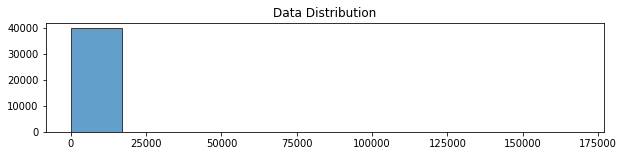

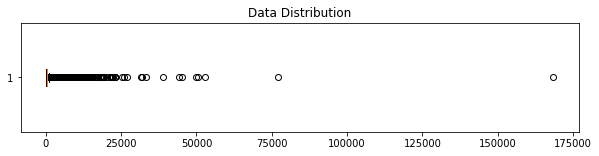

+-------+-----------------+----+-------+------------------+
|Minimum|          Maximum|Mode| Median|              Mean|
+-------+-----------------+----+-------+------------------+
|   0.19|724.2499999999999|15.0|256.235|271.68389129924265|
+-------+-----------------+----+-------+------------------+



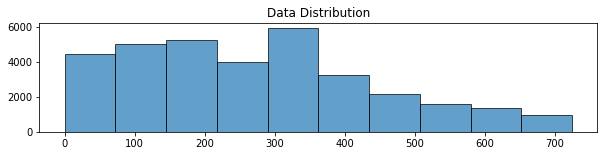

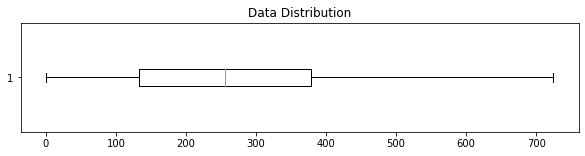

In [0]:
dbutils.fs.cp('/FileStore/tables/online_retail_II.csv', 'file:/tmp/online_retail_II.csv')
file_path = '/tmp/online_retail_II.csv'

retail_df = pd.read_csv(file_path)

def to_camel_case(column):
    parts = column.split()
    return parts[0].lower() + ''.join(word.capitalize() for word in parts[1:])

retail_df.columns = [to_camel_case(col) for col in retail_df.columns]
#retail_df.head()

spark_df = spark.createDataFrame(retail_df)
#spark_df.show()

spark_df = spark_df.withColumn("Amount", col("Quantity") * col("Price"))

invoice_amount_df = spark_df.groupBy("Invoice").agg(
    sum("Amount").alias("Amount")
)

invoice_amount_df.filter(col("Amount") > 0).select(min("Amount").alias("Minimum"), max("Amount").alias("Maximum"), mode("Amount").alias("Mode"), median("Amount").alias("Median"), mean("Amount").alias("Mean")).show()

data = invoice_amount_df.filter(col("Amount") > 0).select("Amount").toPandas()

plt.figure(figsize=(10, 2))
plt.hist(data, edgecolor='k', alpha=0.7)
plt.title("Data Distribution")
plt.show()

plt.figure(figsize=(10, 2))
plt.boxplot(data, vert=False)
plt.title("Data Distribution")
plt.show()

probabilities = [i / 85 for i in range(1, 86)]
invoice_amount_df_filtered = invoice_amount_df.filter(col("Amount") > 0)
quantile_85 = invoice_amount_df_filtered.approxQuantile("Amount", [0.85], 0)[0]
filtered_df = invoice_amount_df_filtered.filter(col("Amount") < quantile_85)
filtered_df.select(min("Amount").alias("Minimum"), max("Amount").alias("Maximum"), mode("Amount").alias("Mode"), median("Amount").alias("Median"), mean("Amount").alias("Mean")).show()

filtered_data = filtered_df.select("Amount").toPandas()

plt.figure(figsize=(10, 2))
plt.hist(filtered_data, edgecolor='k', alpha=0.7)
plt.title("Data Distribution")
plt.show()

plt.figure(figsize=(10, 2))
plt.boxplot(filtered_data, vert=False)
plt.title("Data Distribution")
plt.show()

Out[3]: <AxesSubplot:xlabel='YearMonth'>

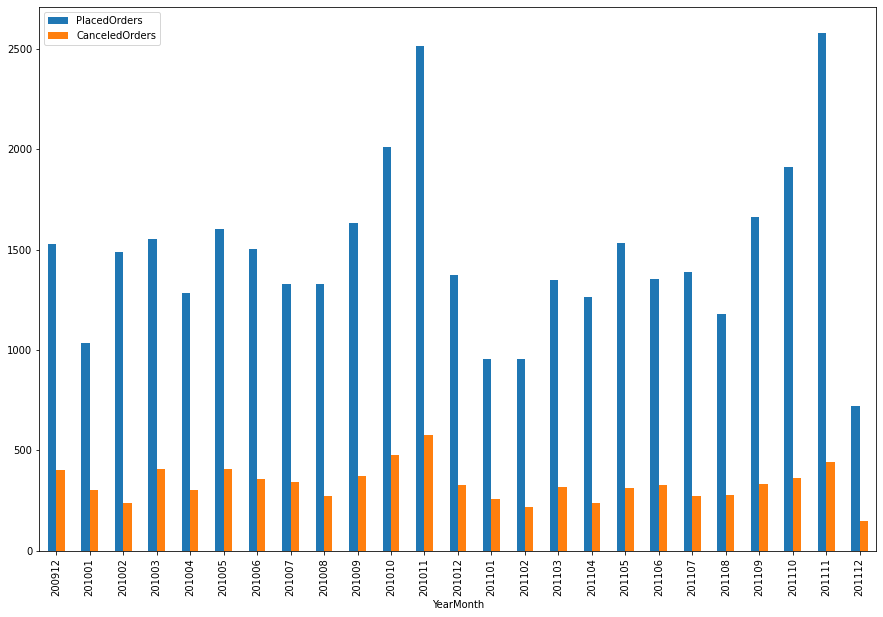

In [0]:
df = spark_df.withColumn("YearMonth", concat(substring(col("InvoiceDate"), 1, 4), substring(col("InvoiceDate"), 6, 2)).cast("string"))

canceled_orders = df.filter(col("Invoice").startswith("C")).groupBy("YearMonth").agg(count_distinct("Invoice").alias("CanceledOrders")).orderBy("YearMonth")
total_orders = df.groupBy("YearMonth").agg(count_distinct("Invoice").alias("TotalOrders")).orderBy("YearMonth")

result_df = total_orders.join(canceled_orders, "YearMonth", "left").withColumn("PlacedOrders", expr("TotalOrders - 2 * CanceledOrders")).orderBy("YearMonth")

order_data = result_df.select('YearMonth', 'PlacedOrders', 'CanceledOrders').toPandas()
order_data.plot(x='YearMonth', y=['PlacedOrders', 'CanceledOrders'], kind='bar', figsize=(15,10))

Out[4]: [Text(0, 0, '200912'),
 Text(1, 0, '201001'),
 Text(2, 0, '201002'),
 Text(3, 0, '201003'),
 Text(4, 0, '201004'),
 Text(5, 0, '201005'),
 Text(6, 0, '201006'),
 Text(7, 0, '201007'),
 Text(8, 0, '201008'),
 Text(9, 0, '201009'),
 Text(10, 0, '201010'),
 Text(11, 0, '201011'),
 Text(12, 0, '201012'),
 Text(13, 0, '201101'),
 Text(14, 0, '201102'),
 Text(15, 0, '201103'),
 Text(16, 0, '201104'),
 Text(17, 0, '201105'),
 Text(18, 0, '201106'),
 Text(19, 0, '201107'),
 Text(20, 0, '201108'),
 Text(21, 0, '201109'),
 Text(22, 0, '201110'),
 Text(23, 0, '201111'),
 Text(24, 0, '201112')]

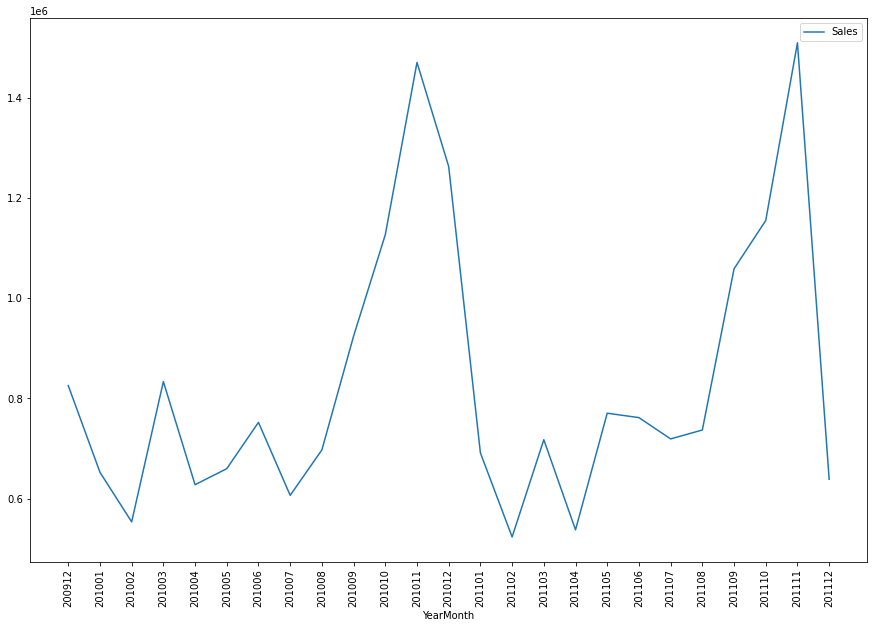

In [0]:
monthly_sales = df.filter(col("Quantity") > 0).groupBy("YearMonth").agg(sum("Amount").alias("Sales"))
sales_data = monthly_sales.select('YearMonth', 'Sales').toPandas()
ax = sales_data.plot(x='YearMonth', y='Sales', kind='line', figsize=(15,10))
ax.set_xticks(range(len(sales_data))) 
ax.set_xticklabels(sales_data["YearMonth"], rotation=90)

Out[5]: [Text(0, 0, '200912'),
 Text(1, 0, '201001'),
 Text(2, 0, '201002'),
 Text(3, 0, '201003'),
 Text(4, 0, '201004'),
 Text(5, 0, '201005'),
 Text(6, 0, '201006'),
 Text(7, 0, '201007'),
 Text(8, 0, '201008'),
 Text(9, 0, '201009'),
 Text(10, 0, '201010'),
 Text(11, 0, '201011'),
 Text(12, 0, '201012'),
 Text(13, 0, '201101'),
 Text(14, 0, '201102'),
 Text(15, 0, '201103'),
 Text(16, 0, '201104'),
 Text(17, 0, '201105'),
 Text(18, 0, '201106'),
 Text(19, 0, '201107'),
 Text(20, 0, '201108'),
 Text(21, 0, '201109'),
 Text(22, 0, '201110'),
 Text(23, 0, '201111'),
 Text(24, 0, '201112')]

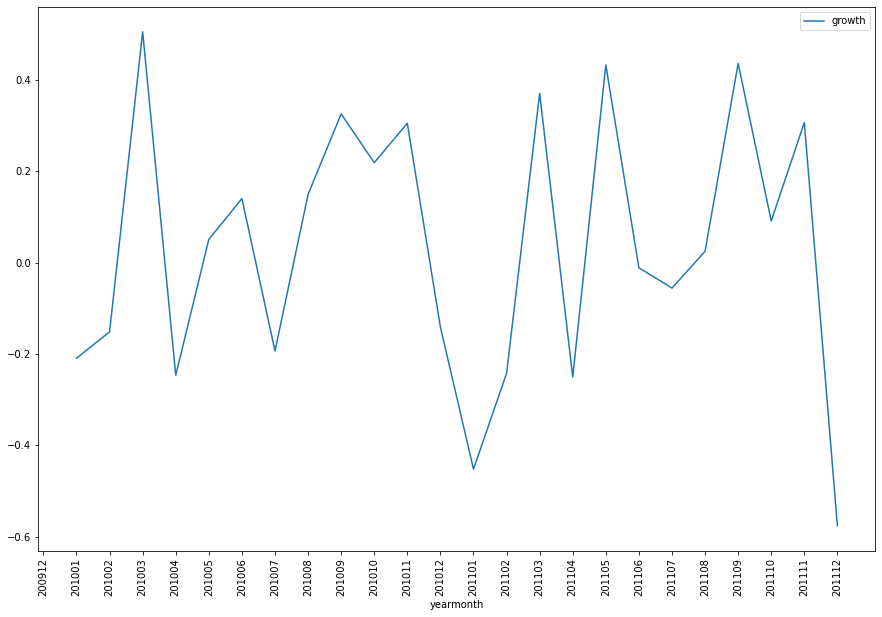

In [0]:
window = Window.orderBy("yearmonth")
monthly_sales_growth = monthly_sales.withColumn("prevSale", lag("sales").over(window))
monthly_sales_growth = monthly_sales_growth.withColumn("growth", (col("sales") - col("prevSale")) / col("prevSale"))
growth_data = monthly_sales_growth.select("yearmonth", "growth").toPandas()
growth_plot = growth_data.plot(x="yearmonth", y="growth", kind="line", figsize=(15,10))
growth_plot.set_xticks(range(len(growth_data)))
growth_plot.set_xticklabels(growth_data["yearmonth"], rotation=90)

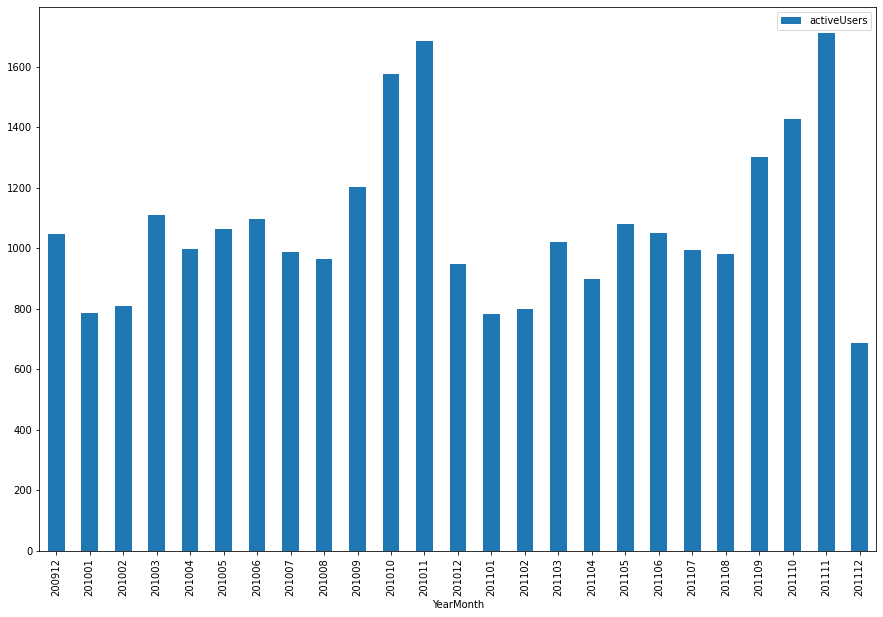

In [0]:
monthly_active_users = df.groupBy("YearMonth").agg(count_distinct("customerId").alias("activeUsers")).orderBy("YearMonth")
user_data = monthly_active_users.select("YearMonth", "activeUsers").toPandas()
user_plot = user_data.plot(x="YearMonth", y="activeUsers", kind="bar", figsize=(15,10))

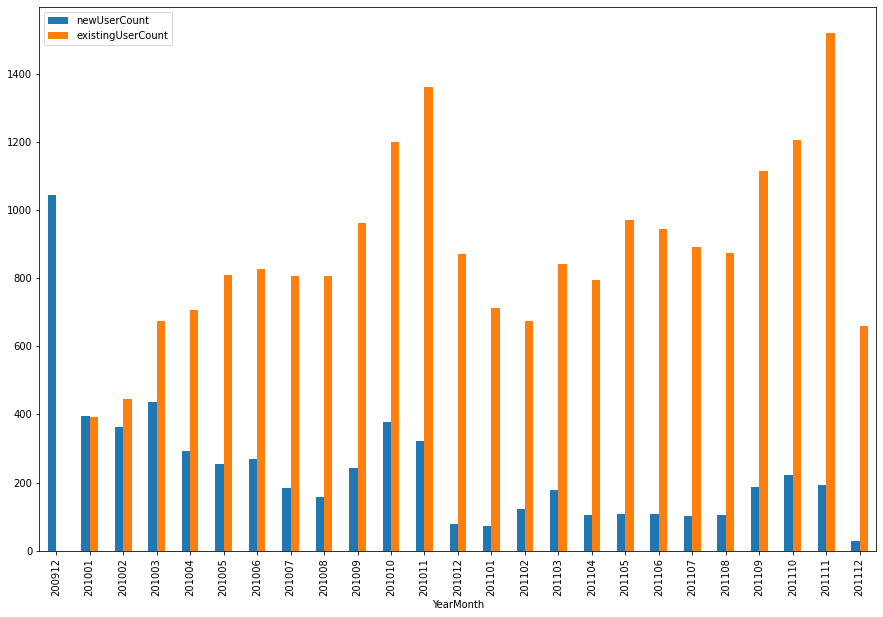

In [0]:
windowSpec = Window.partitionBy("customerId")
new_users = df.withColumn("InvoiceYearMonth", min("yearmonth").over(windowSpec))
new_users = new_users.groupBy("InvoiceYearMonth").agg(count_distinct("customerId").alias("newUserCount")).orderBy("InvoiceYearMonth")
new_users = new_users.withColumnRenamed("InvoiceYearMonth", "YearMonth")
new_ex = new_users.join(monthly_active_users, 'YearMonth', 'inner').orderBy("YearMonth")
new_ex = new_ex.withColumn("existingUserCount", col("activeUsers") - col("newUserCount"))
new_ex_data = new_ex.select("existingUserCount", "newUserCount", "YearMonth").toPandas()
new_ex_plot = new_ex_data.plot(x='YearMonth', y=['newUserCount', 'existingUserCount'], kind='bar', figsize=(15,10))

In [0]:
r = df.withColumn("Recency", datediff(current_date(), col("invoicedate")))
r = r.groupBy("CustomerId").agg(min("Recency").alias("Recency"))

f = df.groupBy("CustomerId").agg(count_distinct("invoice").alias("Frequency"))

m = df.groupBy("CustomerId").agg(sum("Amount").alias("Monetary"))

rfm = r.join(f, "CustomerId", "inner").join(m, "CustomerId", "inner").orderBy("CustomerId").show()

+----------+-------+---------+------------------+
|CustomerId|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|   12346.0|   5166|       17|-64.68000000000002|
|   12347.0|   4843|        8|           5633.32|
|   12348.0|   4916|        5|            2019.4|
|   12349.0|   4859|        5|           4404.54|
|   12350.0|   5151|        1|334.40000000000003|
|   12351.0|   5216|        1|            300.93|
|   12352.0|   4877|       13|           1889.21|
|   12353.0|   5045|        2|406.75999999999993|
|   12354.0|   5073|        1|            1079.4|
|   12355.0|   5055|        2| 947.6099999999999|
|   12356.0|   4863|        6| 6373.680000000001|
|   12357.0|   4874|        3| 18287.65999999999|
|   12358.0|   4842|        5|3887.0700000000006|
|   12359.0|   4848|       14|           8714.89|
|   12360.0|   4893|        9| 4212.889999999999|
|   12361.0|   5128|        4|            511.25|
|   12362.0|   4844|       14| 5284.579999999999|


In [0]:
retail_df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerId,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [0]:
retail_df['TotalPrice'] = retail_df['price'] * retail_df['quantity']
today = pd.datetime(2012,1,1)
retail_df['invoicedate'] = pd.to_datetime(retail_df['invoicedate'])

retail_df = retail_df[retail_df['quantity'] > 0]
retail_df = retail_df[retail_df['TotalPrice'] > 0]
retail_df.dropna(inplace = True)

retail_df_x = retail_df.groupby('customerId').agg({'TotalPrice': lambda x: x.sum(), 'invoicedate': lambda x: (today - x.max()).days})
retail_df_y = retail_df.groupby(['customerId','invoice']).agg({'TotalPrice': lambda x: x.sum()})
retail_df_z = retail_df_y.groupby('customerId').agg({'TotalPrice': lambda x: len(x)}) 

rfm_table = pd.merge(retail_df_x, retail_df_z, on='customerId')
rfm_table.rename(columns= {'invoicedate': 'Recency','TotalPrice_y': 'Frequency','TotalPrice_x': 'Monetary'}, inplace= True)

rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'],5,labels=[5,4,3,2,1])
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'],5,labels=[1,2,3,4,5])

rfm_table['RFM_SCORE'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)

#rfm_table.head()
#rfm_table.describe().T
#rfm_table[rfm_table["RFM_SCORE"] == "555"].head()
#rfm_table[rfm_table["RFM_SCORE"] == "111"].head()
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)
rfm_table.head()
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

<command-3565594356678478>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(2012,1,1)


Recency 
 Frequency 
 Monetary 
 
 
 
 mean 
 count 
 mean 
 count 
 mean 
 count 
 
 
 Segment 
 
 
 
 
 
 
 
 
 
 
 About to Sleep 
 128.618557 
 388 
 1.360825 
 388 
 531.969905 
 388 
 
 
 At Risk 
 394.942667 
 750 
 3.904000 
 750 
 1383.596253 
 750 
 
 
 Can't Lose 
 352.802817 
 71 
 15.929577 
 71 
 8355.677634 
 71 
 
 
 Champions 
 30.250000 
 852 
 19.214789 
 852 
 10795.520581 
 852 
 
 
 Hibernating 
 481.012484 
 1522 
 1.252300 
 1522 
 437.963135 
 1522 
 
 
 Loyal Customers 
 89.306016 
 1147 
 9.802964 
 1147 
 4199.728592 
 1147 
 
 
 Need Attention 
 135.241636 
 269 
 3.156134 
 269 
 1283.114015 
 269 
 
 
 New Customers 
 32.303571 
 56 
 1.000000 
 56 
 356.257857 
 56 
 
 
 Potential Loyalists 
 47.297335 
 713 
 2.589060 
 713 
 1155.427281 
 713 
 
 
 Promising 
 60.281818 
 110 
 1.000000 
 110 
 324.497000 
 110